# Feature Engineering and Modeling

In this notebook, we are performing feature selection and exploratory data analysis to analyse more in depth on the features selected so that we can make more improvement during the next iteration. 

Contents:
- [Import Library and Load Dataset](#Import-Library-and-Load-Dataset)
- [Feature Selection](#Feature-Selection)
- [Scatter Plots](#Scatter-Plots)
- [Histograms](#Histograms)
- [Model Prep](#Model-Prep)
- [Scaling](#Scaling)
- [Instantiate Models and Cross Validation](#Instantiate-Models-and-Cross-Validation)
- [Model Fitting and Evaluation](#Model-Fitting-and-Evaluation)

## Import Library and Load Dataset

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from sklearn.metrics import r2_score
from sklearn import metrics
from scipy.stats import norm

In [2]:
train = pd.read_csv('../datasets/train_featured.csv')
test = pd.read_csv('../datasets/test_featured.csv')

## Feature Selection

We will first create a function that shows features that have at least a score of 0.5 in correlation with the Sale Price and plot the heatmap for easier visualisation. From there, we will select features base on their correlation to the Sale Price and also remove features that may result in multicollinearity

In [3]:
# Function to get top correlation and plot heatmap

def top_corr_and_plot(dataframe, target):
    top_corr_list = []
    cor = dataframe.corr()
    cor_target = (cor[target])
    pos_corr = cor_target[cor_target>0.5].sort_values(ascending = False)
    neg_corr = cor_target[cor_target < -0.5].sort_values()    
    
    for i in pos_corr.index:
        top_corr_list.append(i)
    for j in neg_corr.index:
        top_corr_list.append(j)
    
    # Generate a mask for the upper triangle
    mask = np.zeros_like(dataframe[top_corr_list].corr(), dtype=np.bool)
    mask[np.triu_indices_from(mask)] = True
    
    # plot heatmap with top correlation
    plt.figure(figsize = [10, 10]) # plot figure should always be on top
    plt.title('Correlation Heat Map')
    ax = sns.heatmap(dataframe[top_corr_list].corr(), annot=True, vmin = -1, vmax = 1, linewidth = 0.8, cmap="Blues", cbar=False, mask = mask, square = True);
    #ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
    ax.set_ylim(18, 1);
    #print(ax.get_ylim())
    
    print('Top correlated columns to sale price are:\n{}'.format(top_corr_list))

In [4]:
train.head()

,Id,PID,Lot Frontage,Lot Area,Utilities,Overall Qual,Overall Cond,Year Built,Year Remod/Add,Mas Vnr Area,...,MS SubClass_1-STORY W/FINISHED ATTIC ALL AGES,MS SubClass_2 FAMILY CONVERSION - ALL STYLES AND AGES,MS SubClass_2-1/2 STORY ALL AGES,MS SubClass_2-STORY 1945 & OLDER,MS SubClass_2-STORY 1946 & NEWER,MS SubClass_2-STORY PUD - 1946 & NEWER,MS SubClass_DUPLEX - ALL STYLES AND AGES,MS SubClass_PUD - MULTILEVEL - INCL SPLIT LEV/FOYER,MS SubClass_SPLIT FOYER,MS SubClass_SPLIT OR MULTI-LEVEL
0,109,533352170,69.017462,13517.0,4,6,8,1976,2005,289.0,...,0,0,0,0,1,0,0,0,0,0
1,544,531379050,43.000000,11492.0,4,7,5,1996,1997,132.0,...,0,0,0,0,1,0,0,0,0,0
2,153,535304180,68.000000,7922.0,4,5,7,1953,2007,0.0,...,0,0,0,0,0,0,0,0,0,0
3,318,916386060,73.000000,9802.0,4,5,5,2006,2007,0.0,...,0,0,0,0,1,0,0,0,0,0
4,255,906425045,82.000000,14235.0,4,6,8,1900,1993,0.0,...,0,0,0,0,0,0,0,0,0,0


Top correlated columns to sale price are:
['SalePrice', 'Overall Qual', 'Exter Qual', 'Gr Liv Area', 'Kitchen Qual', 'Garage Area', 'Total Bsmt SF', '1st Flr SF', 'Bsmt Qual', 'Year Built', 'Garage Finish', 'Year Remod/Add', 'Fireplace Qu', 'Full Bath', 'Mas Vnr Area', 'TotRms AbvGrd', 'Age When Sold', 'Age After Remodeled When Sold']


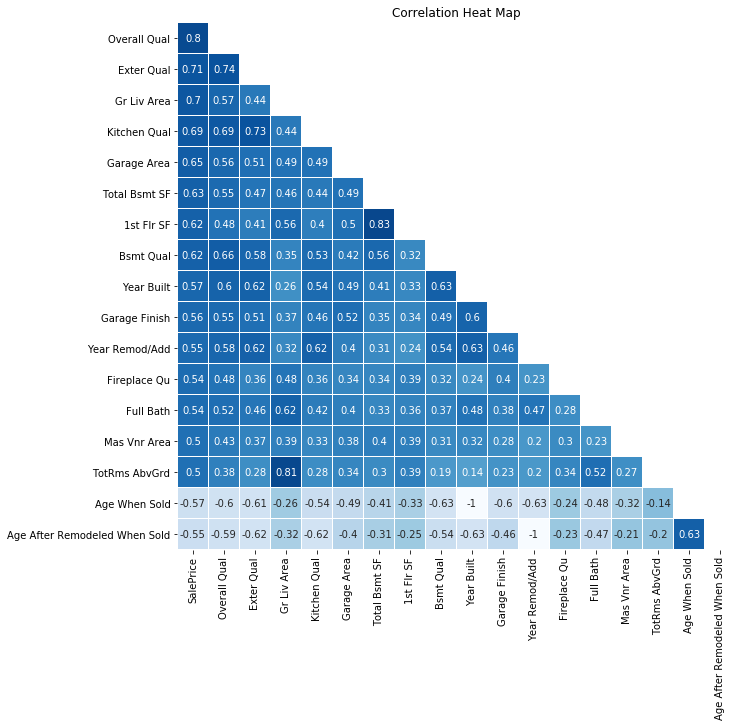

In [5]:
top_corr_and_plot(train, 'SalePrice')

We shall only include independent variables that are not highly correlated with each other. Should 2 independent variables be more highly correlated than they are correlated to the Sale Price, we will keep the one that is more correlated to Sales Price.

With that we have refined our column list and they are listed below

In [6]:
filtered = train[['SalePrice', 'Overall Qual', 'Gr Liv Area', 'Garage Area', 'Total Bsmt SF', 'Garage Finish', 'Fireplace Qu', 
                  'Mas Vnr Area', 'Age When Sold', 'Age After Remodeled When Sold']]

## Scatter Plots

We shall draw the scatter plot for features with continous values to detect any outliers and see its correlation with sale price. Columns with discrete value will not be drawn as they will not yield any useful information

In [7]:
def subplot_scatter(dataframe, column_x, column_y):
    nrows = int(np.ceil(len(column_x)/2)) # Makes sure you have enough rows
    #ncols = int(len(column_x))
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10))
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, (columnx, columny) in enumerate(zip(column_x, column_y)): # Gives us an index value to get into all our lists
        sns.regplot(x = columnx, y = columny, data = dataframe, ax = ax[i], color ='b')
        ax[i].set_title('Scatter of {} and {}'.format(column_x[i], column_y[i]), fontsize = 25)
        ax[i].set_xlabel(column_x[i].replace('_', ' ').title(), fontsize = 25)
        ax[i].set_ylabel(column_y[i].replace('_', ' ').title(), fontsize = 25)
        ax[i].tick_params(labelsize=25)
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

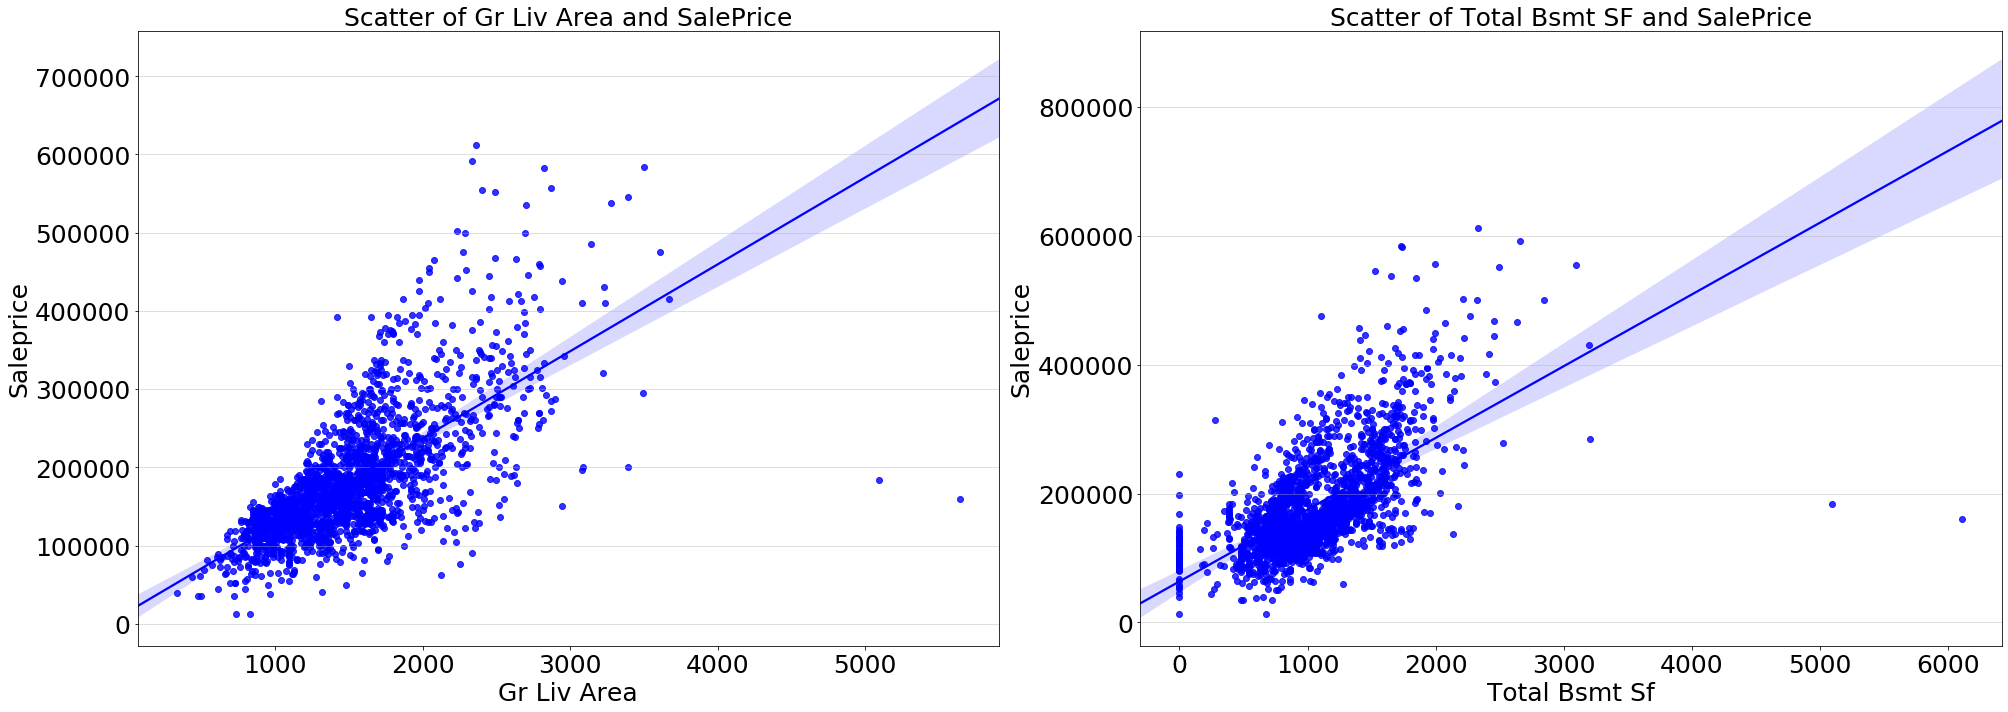

In [8]:
target = 'SalePrice'
x = ['Gr Liv Area', 'Total Bsmt SF']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Gr living area has 2 outliers which is above 5000, they could be from the same rows
- Total Bsmt Sf has 2 outliers which is above 5000.
- We will remove these outliers in the next iteration  

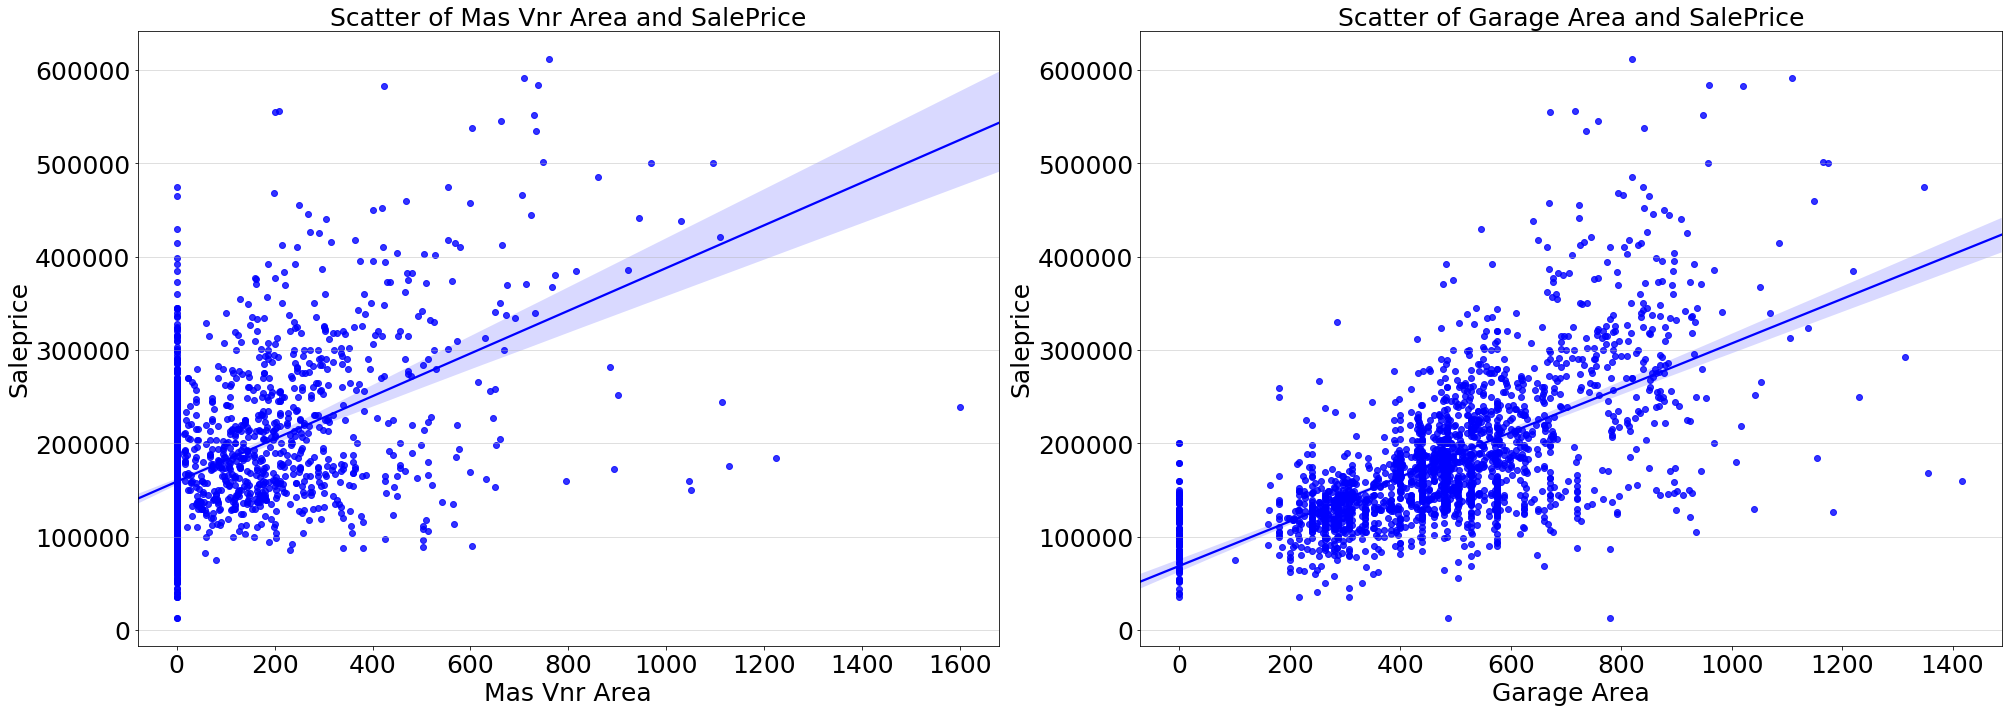

In [9]:
target = 'SalePrice'
x = ['Mas Vnr Area', 'Garage Area']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- Mas Vnr Area has 1 outliers which is above 1600.
- There are quite a number of zeros for garage area. They are properties without any garage. We shall leave them as it is
- We shall remove Mas Vnr Area's outlier in the next iteration
 

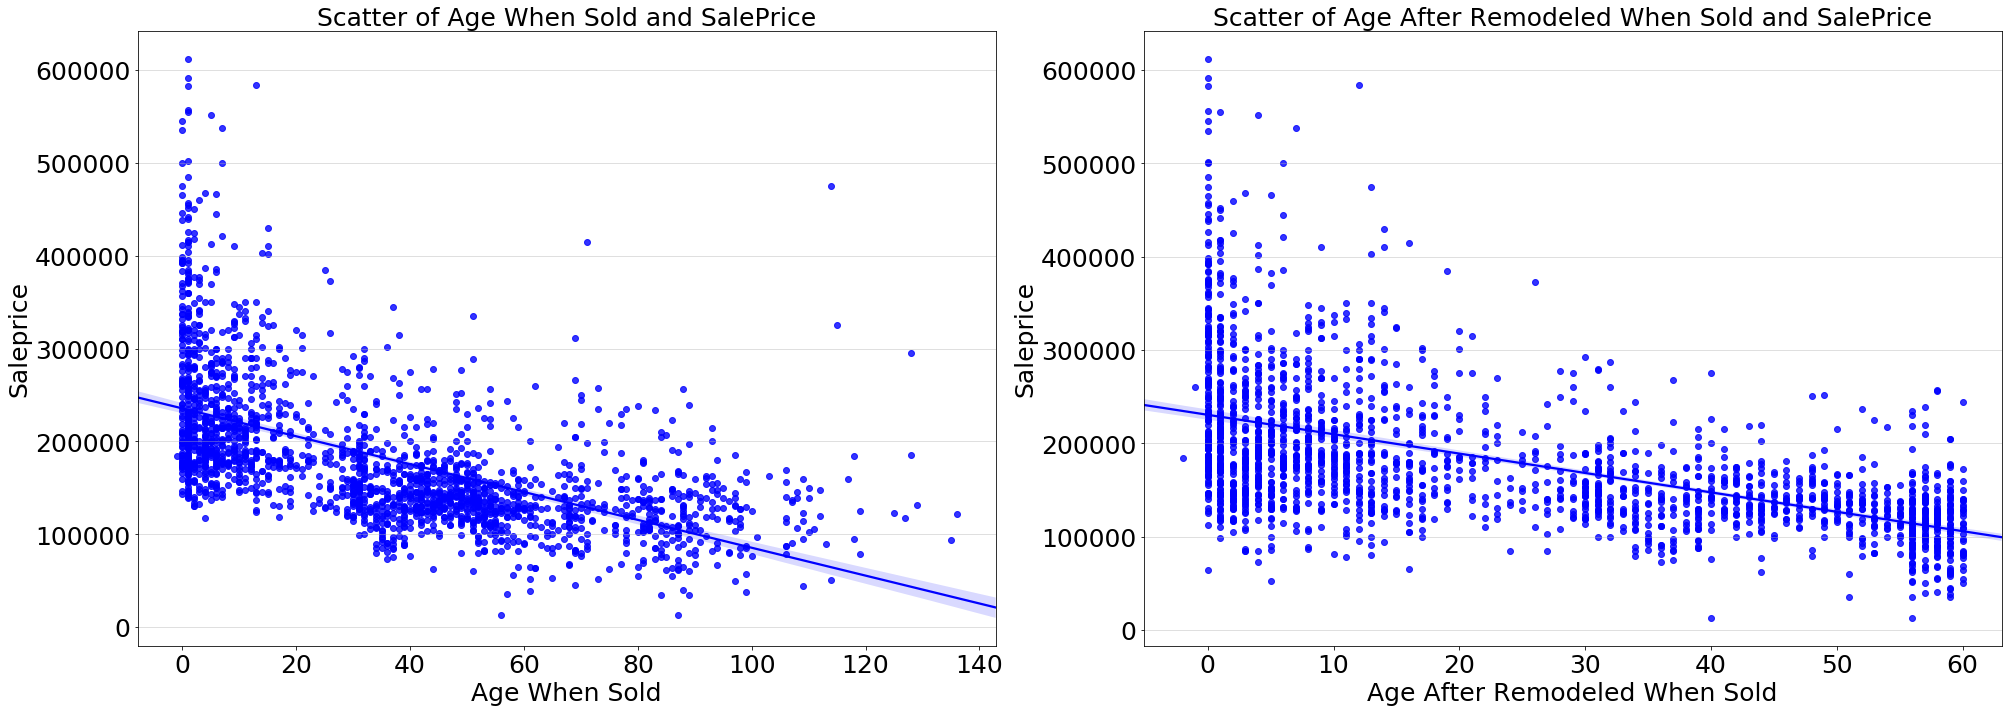

In [10]:
target = 'SalePrice'
x = ['Age When Sold', 'Age After Remodeled When Sold']
y = [target for i in range(len(x))]
subplot_scatter(filtered, x, y)

- There are no distinct observations from Age When Sold and Age After Remodeled When Sold.

## Histograms

We shall draw histograms to look at the distribution of our selected features

In [11]:
def subplot_histograms(dataframe, list_of_columns, ylabel = 'Probability Density Function'):
    nrows = int(np.ceil(len(list_of_columns)/2)) # Makes sure you have enough rows
    fig, ax = plt.subplots(nrows=nrows, ncols=2, figsize = (28, 10)) # You'll want to specify your figsize
    ax = ax.ravel() # Ravel turns a matrix into a vector, which is easier to iterate
    for i, column in enumerate(list_of_columns): # Gives us an index value to get into all our lists
        sns.distplot(dataframe[column], ax = ax[i], bins = 10, fit = norm, kde = True)
        mean = dataframe[column].mean()
        ax[i].set_title('{} Distribution'.format(list_of_columns[i]), fontsize = 25)
        ax[i].set_xlabel(list_of_columns[i], fontsize = 25)
        ax[i].tick_params(labelsize=25)
        ax[i].set_ylabel(ylabel, fontsize = 25)
        ax[i].axvline(mean, color = 'r')
        ax[i].grid(axis = 'y', alpha = 0.5) # set grid line, alpha is transparency
        fig.tight_layout()

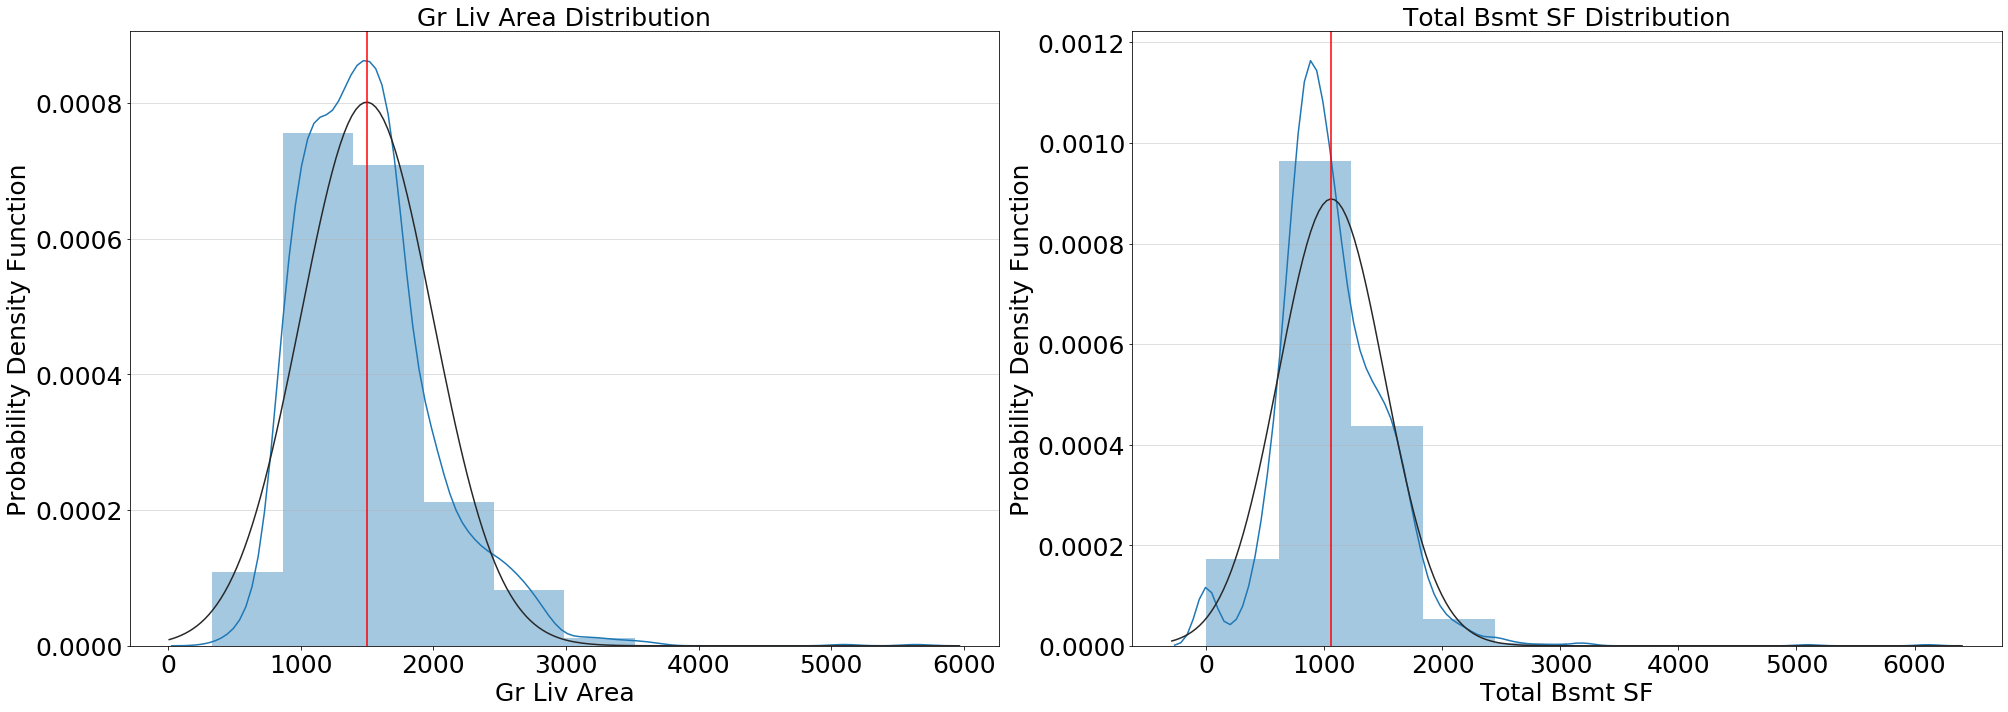

In [12]:
list_of_columns = ['Gr Liv Area', 'Total Bsmt SF']

subplot_histograms(filtered, list_of_columns)

- Gr Liv Area is slightly skewed to the right and it is somehow distributed. The mode is near to the mean
- Total Bsmt SF is slightly skewed to the right and it is somehow distributed. The mode is near to the mean
- We also observe that there are outliers to the right of both plots, this is confirmed from the scatter plot

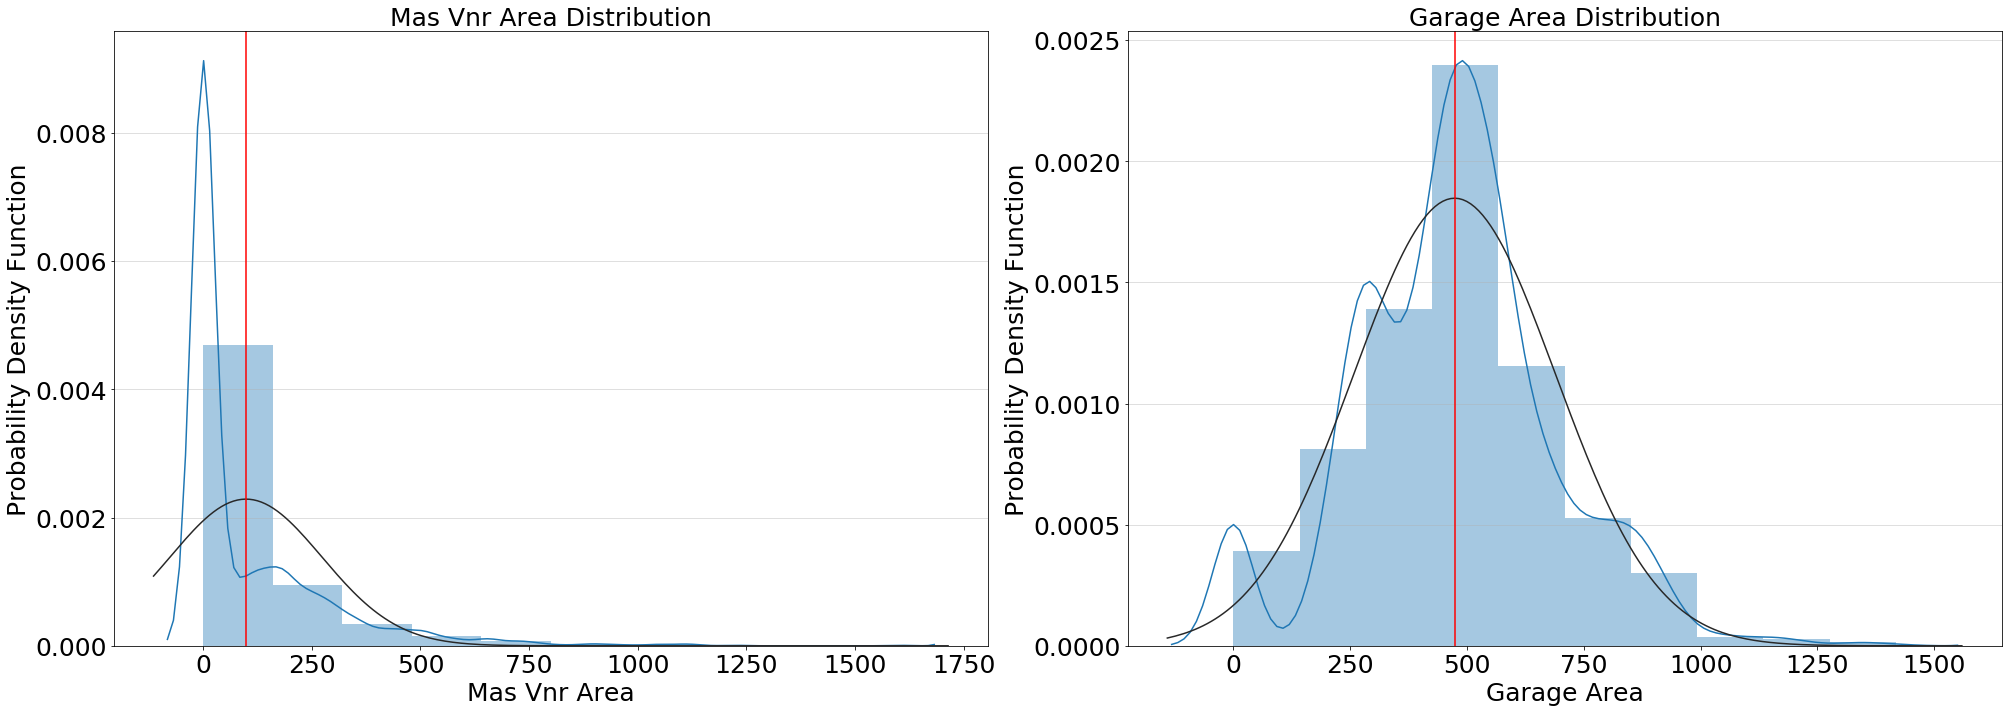

In [13]:
list_of_columns = ['Mas Vnr Area', 'Garage Area']

subplot_histograms(filtered, list_of_columns)

- Mas Vnr Area is heavily skewed to the right and we can see that the there are some outliers as confirmed from the scatter plot drawn earlier
- Mas Vnr Area's mode is near to the mean
- Garage Area's distribution looks to be quite normal, the skew is minimal and the mean is near the mode. We can also see that there are zeros based on the distribution plot, this are properties without garage

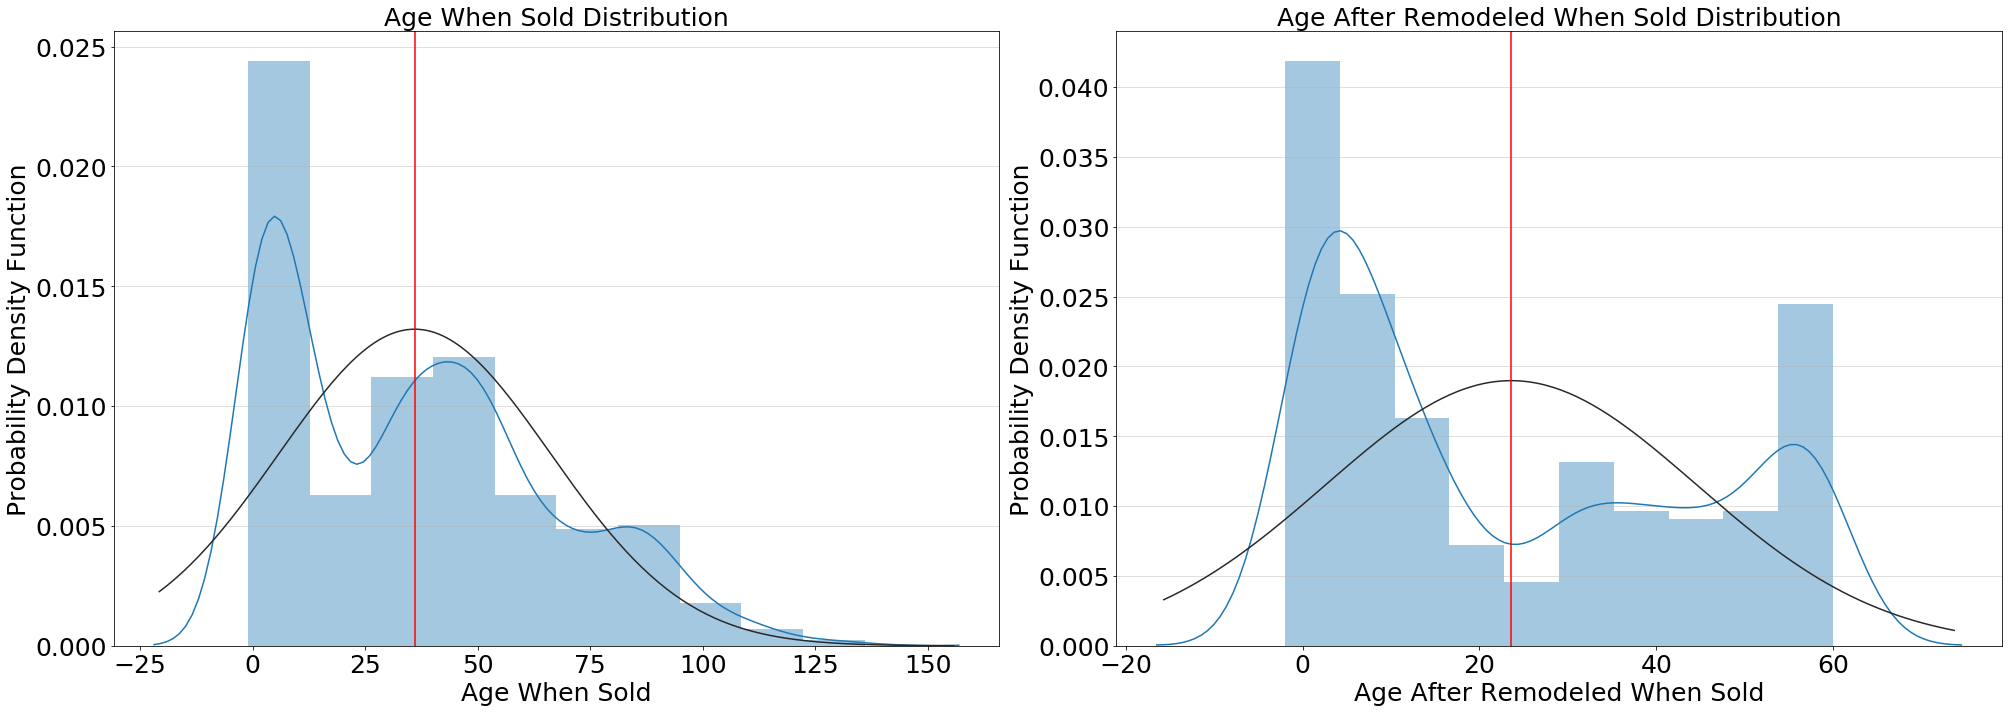

In [14]:
list_of_columns = ['Age When Sold', 'Age After Remodeled When Sold']

subplot_histograms(filtered, list_of_columns)

- We can see that both Age When Sold and Age After Remodeled When Sold's distribution plot is not normally distributed and their mean is not near to the mode 

## Model Prep

In [15]:
features = [col for col in filtered.columns if col != 'SalePrice']
X = filtered[features]
y = filtered['SalePrice']

In [16]:
X_train, X_test, y_train, y_test = train_test_split( X, y, random_state=42)

## Scaling

In [17]:
ss = StandardScaler()
ss.fit(X_train)
X_train = ss.transform(X_train)
X_test = ss.transform(X_test)

## Instantiate Models and Cross Validation

In [18]:
# a function to get the score for linear regression, lasso and ridge

def score(X_train, y_train):
    lr = LinearRegression()
    lasso = LassoCV(cv = 3)
    ridge = RidgeCV()
    
    lr_scores = cross_val_score(lr, X_train, y_train, cv=5)
    lr_scores.mean()
    print('Linear Regression mean score is: {}'.format(lr_scores.mean()))
    
    lasso_scores = cross_val_score(lasso, X_train, y_train, cv=5)
    lasso_scores.mean()
    print('Lasso mean score is: {}'.format(lasso_scores.mean()))
    
    ridge_scores = cross_val_score(ridge, X_train, y_train, cv=5)
    ridge_scores.mean()
    print('Ridge mean score is: {}'.format(ridge_scores.mean()))
    

In [19]:
score(X_train, y_train)

Linear Regression mean score is: 0.7849417577452041
Lasso mean score is: 0.7842343240195507
Ridge mean score is: 0.7851195320740479


We can see that ridge is the best. We shall use ridge to fit our model and check for the score

## Model Fitting and Evaluation

In [20]:
# Fit the model using ridge

ridge = RidgeCV()
ridge.fit(X_train, y_train)
train_score = ridge.score(X_train, y_train)
test_score = ridge.score(X_test, y_test)
pred = ridge.predict(X_test)
rsme = np.sqrt(metrics.mean_squared_error(pred, y_test))
residuals = y_test - pred
coef = ridge.coef_
print('Train Score is {}'.format(train_score))
print('Test Score is {}'.format(test_score))
print('Root Mean Square Error is {}'.format(rsme))

Train Score is 0.7912210733122489
Test Score is 0.8357337216438807
Root Mean Square Error is 31540.12149279606


In [21]:
# Function to plot Coefficient

def plot_ridge_coref(coef):    

    coefficent_series = pd.Series(coef, index=features)

    plt.figure(1, figsize = (12, 5))
    plt.title('Ridge Coefficient', fontsize = 20)
    plt.xlabel('Price', fontsize = 15)
    plt.ylabel('Features', fontsize = 15)
    plt.barh(coefficent_series.index, coefficent_series.values)

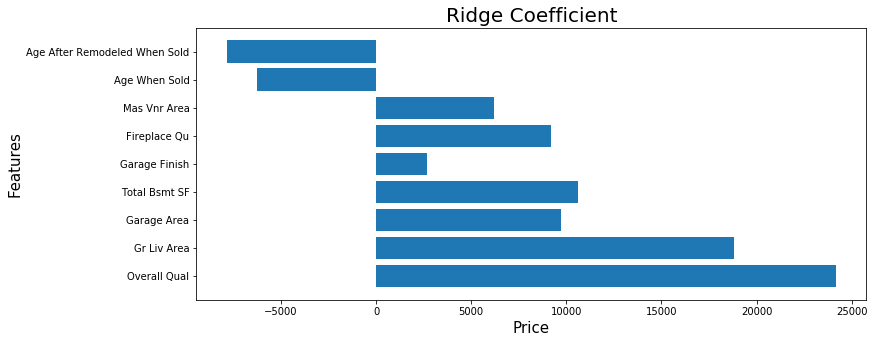

In [22]:
plot_ridge_coref(coef)

From the above coefficient plot, we can see that
- 1 unit increase in Age After Remodeled When Sold is equals to around 8000 decrease in Sale Price
- 1 unit increase in Age When Sold is equals to around 5000 decrease in Sale Price
- 1 unit increase in Mas Vnr Area is equals to around 7000 increase in Sale Price
- 1 unit increase in Fireplace Qu is equals to around 8000 increase in Sale Price
- 1 unit increase in Garage Finish is equals to around 3000 increase in Sale Price
- 1 unit increase in Total Bsmt SF is equals to around 11000 increase in Sale Price
- 1 unit increase in Garage Area is equals to around 9000 increase in Sale Price
- 1 unit increase in Gr Liv Area is equals to around 18000 increase in Sale Price
- 1 unit increase in Overall Qual is equals to around 24000 increase in Sale Price

In [23]:
def plot_pred_residual_scatter(pred, residuals):    
    plt.figure(3, figsize = (14.65, 5))
    plt.title('Prediction and Residual Plot - 1st Iteration', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Residual', fontsize = 15)
    plt.tick_params(labelsize=15)
    plt.scatter(pred, residuals)
    plt.axhline(0, color='r')

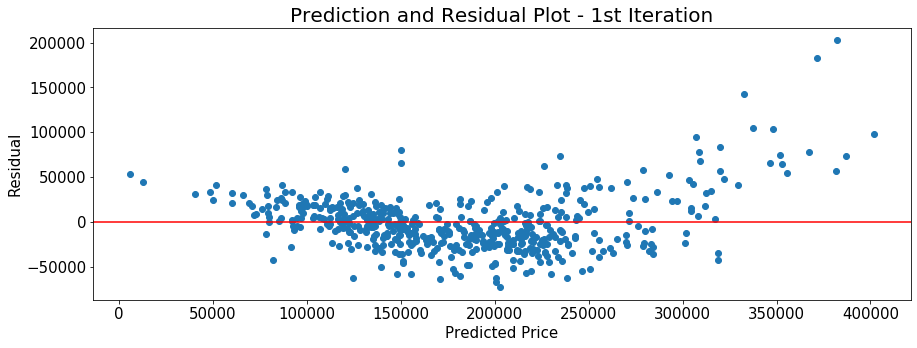

In [24]:
plot_pred_residual_scatter(pred, residuals)

From the above prediction and residual scatter plot, we can see that the plots are somehow heteroscedastic, the points are somehow evenly distributed around the mean. We can see that as the predicted price gets higher the heteroscedastic characteristics decreases. More improvements can be made

In [25]:
def plot_pred_actual_scatter(pred, y_test):    
    plt.figure(2, figsize = (14.65, 5))
    plt.title('Predict and Actual Scatter Plot - 1st Iteration', fontsize = 20)
    plt.xlabel('Predicted Price', fontsize = 15)
    plt.ylabel('Actual Price', fontsize = 15)
    plt.tick_params(labelsize=15)
    sns.regplot(pred, y_test);

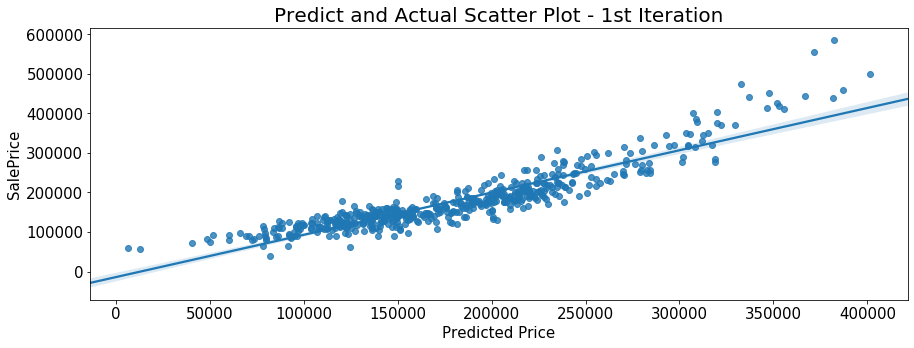

In [26]:
plot_pred_actual_scatter(pred, y_test) 

From the above predict and actual scatter plot, we can see that the predicted price and actual price are correlated. Similar to the residual plot, we can see that as the predicted price increase, the plots become more scatter

We found out predictors which are more correlated to sale price and can see that there are some outliers to remove. We also got a sense of what category of features will be good predictors. We will perform the next iterateration in the next notebook.